# atmaCup#10 - 美術作品の評価予測

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error as MSE, mean_squared_log_error as MSLE

import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from matplotlib_venn import venn2

import os
from typing import List, Tuple, Callable
from pathlib import Path
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter('ignore')

In [3]:
import sys
sys.path.append('..')

from common_modules.util import *
from common_modules.feature import *
from common_modules.visualization import *

from modules.feature import *
from modules.train import *

%load_ext autoreload
%autoreload 2

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Util Functions

In [4]:
def input_dir():
    return Path("input")

def output_dir():
    return Path("output")

## Load Data

### art object

In [5]:
train_df = pd.read_csv(os.path.join(input_dir() / "train.csv"))
test_df = pd.read_csv(os.path.join(input_dir() / "test.csv"))
print(train_df.shape, test_df.shape)

(12026, 19) (12008, 18)


In [18]:
whole_df = pd.concat([train_df.drop(columns=['likes']).reset_index(), 
                      test_df.reset_index()], axis=0)

In [6]:
train_df.head().T

,0,1,2,3,4
object_id,0011d6be41612ec9eae3,0012765f7a97ccc3e9e9,0017be8caa87206532cb,00181d86ff1a7b95864e,001c52ae28ec106d9cd5
art_series_id,93c092ba70beab248f31,95c14fb11c54281ad7e0,4c406890d208fe01f8fb,fa0891535500a4973db2,8065ed5063c5887e677d
title,The Avenue of Birches,Struik in bloei,Portret van een vrouw,A St Bernard Dog,Woelige zee met zeilschepen
description,NaN,NaN,"Portret van eenvrouw, zittend naast een tafel.","Een sint-bernardshond, staand in een landschap...",Woelige zee met zeilschepen.
long_title,"The Avenue of Birches, Jan Hackaert, 1660 - 1685","Struik in bloei, Richard Tepe (attributed to),...","Portret van een vrouw, Tresling & Comp., 1860 ...","A St Bernard Dog, Bernard te Gempt, c. 1850 - ...","Woelige zee met zeilschepen, anonymous, 1825 -..."
principal_maker,Jan Hackaert,Richard Tepe,Tresling & Comp.,Bernard te Gempt,anonymous
principal_or_first_maker,Jan Hackaert,Richard Tepe,Tresling & Comp.,Bernard te Gempt,anonymous
sub_title,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,h 165mm × w 223mm,h 87mm × w 56mm,h 179cm × w 248cm × t 4cm,h 13cm × w 17.5cm × d 0.7cm
copyright_holder,NaN,erven Richard Tepe,NaN,NaN,NaN
more_title,The Avenue of Birches,Struik in bloei,Portret van een vrouw,A St Bernard Dog,Woelige zee met zeilschepen


os.makedirs(output_dir() / "profile", exist_ok=True)

report = ProfileReport(train_df)
report.to_file(os.path.join(output_dir() / 'profile/train_report.html'))

In [7]:
def read_csv(name:str)->pd.DataFrame():
    output_df = pd.read_csv(os.path.join(input_dir() / f"{name}.csv"))
    return output_df

## Feature Engineering

### Get Train Feature Data

In [79]:
fold = GroupKFold(n_splits=5)
cv = list(fold.split(train_df, groups=train_df['art_series_id']))

In [80]:
df_name = ['palette', 'material', 'historical_person', 'object_collection', 
           'production_place', 'technique', 'maker', 'principal_maker']

In [86]:
process_blocks = [
    NumericBlock(),
    
    *[One2ManyBlock(name) for name in
      ['material', 'technique', 'production_place', 'historical_person', 'object_collection']],
    
    *[RelationCountBlock(name) for name in
          ['material',
           'technique',
           'production_place',
           'historical_person',
           'color',
           'principal_maker']
          ],
    
    *[stringLengthBlock(col) for col in ['title', 'long_title', 'sub_title', 'more_title', 'description']],
    
    *[AggregationBlock(table_name) for table_name in ['material', 'historical_person']],
    
    *[CountEncoding(col, whole_df) for col in ['acquisition_method', 'title', 'dating_period',
                                               'principal_maker', 'copyright_holder']],
    
    *[TargetEncoding(col, 'likes', cv) for col in ['title', 'long_title', 'dating_period', 'acquisition_method', 'acquisition_date']],
    
    *[Word2vecBlock(whole_df, col) for col in ['title', 'more_title', 'sub_title', 'long_title', 'description']],
    *[TfidfBlock(col) for col in ['title', 'more_title', 'sub_title','long_title', 'description']],
    
    SizeExtractionBlock(whole_df),
    OneHotEncoding(col='acquisition_method', threshold=100),
    OneHotEncoding(col='principal_maker', threshold=200)
]

In [87]:
train_feat_df = to_features(train_df, process_blocks, is_train=True)
test_feat_df = to_features(test_df, process_blocks)

  0%|          | 0/42 [00:00<?, ?it/s]

create NumericBlock fit 0.001[s]
create One2ManyBlock fit 0.295[s]
create One2ManyBlock fit 0.185[s]
create One2ManyBlock fit 0.214[s]
create One2ManyBlock fit 0.041[s]
create One2ManyBlock fit 0.116[s]
create RelationCountBlock fit 0.040[s]
create RelationCountBlock fit 0.027[s]
create RelationCountBlock fit 0.026[s]
create RelationCountBlock fit 0.021[s]
create RelationCountBlock fit 0.062[s]
create RelationCountBlock fit 0.048[s]
create stringLengthBlock fit 0.004[s]
create stringLengthBlock fit 0.003[s]
create stringLengthBlock fit 0.004[s]
create stringLengthBlock fit 0.005[s]
create stringLengthBlock fit 0.005[s]
create AggregationBlock fit 0.044[s]
create AggregationBlock fit 0.019[s]
create CountEncoding fit 0.003[s]
create CountEncoding fit 0.012[s]
create CountEncoding fit 0.002[s]
create CountEncoding fit 0.004[s]
create CountEncoding fit 0.004[s]
create TargetEncoding fit 0.086[s]
create TargetEncoding fit 0.099[s]
create TargetEncoding fit 0.029[s]
create TargetEncoding fi

  0%|          | 0/42 [00:00<?, ?it/s]

create NumericBlock transform 0.002[s]
create One2ManyBlock transform 0.025[s]
create One2ManyBlock transform 0.018[s]
create One2ManyBlock transform 0.038[s]
create One2ManyBlock transform 0.018[s]
create One2ManyBlock transform 0.010[s]
create RelationCountBlock transform 0.012[s]
create RelationCountBlock transform 0.013[s]
create RelationCountBlock transform 0.010[s]
create RelationCountBlock transform 0.016[s]
create RelationCountBlock transform 0.016[s]
create RelationCountBlock transform 0.010[s]
create stringLengthBlock transform 0.006[s]
create stringLengthBlock transform 0.004[s]
create stringLengthBlock transform 0.007[s]
create stringLengthBlock transform 0.009[s]
create stringLengthBlock transform 0.009[s]
create AggregationBlock transform 0.009[s]
create AggregationBlock transform 0.007[s]
create CountEncoding transform 0.005[s]
create CountEncoding transform 0.016[s]
create CountEncoding transform 0.004[s]
create CountEncoding transform 0.006[s]
create CountEncoding tran

os.makedirs(output_dir() / "profile", exist_ok=True)

feature_report = ProfileReport(train_feat_df)
feature_report.to_file(os.path.join(output_dir() / 'profile/train_feat_report.html'))

## Train Model

### LGBM

In [89]:
SEED = 3655

LGBM_PARAMS = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'regression', 
    'metric':'rmse',

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .05,

    # L2 Reguralization
    'reg_lambda': .001,
    # こちらは L1 
    'reg_alpha': .001,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 8, 
    'num_leaves': 180,

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 50_000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5, 

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 5,
    'min_child_weight':18,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': SEED
}

LGBM_FIT_PARAMS = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 500,
    'verbose': 500,
}

In [90]:
y = train_df['likes'].values

models, oof_pred = fit_lgbm(X=train_feat_df.values, 
                            y=y,
                            cv=cv, 
                            params=LGBM_PARAMS, 
                            fit_params=LGBM_FIT_PARAMS)

Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 0.173231	valid_1's rmse: 0.995007
[1000]	training's rmse: 0.0972212	valid_1's rmse: 0.996006
Early stopping, best iteration is:
[586]	training's rmse: 0.147973	valid_1's rmse: 0.994539
fit fold=1	46.300[s]

fold 1 RMSLE: 0.99

Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 0.170332	valid_1's rmse: 1.02851
Early stopping, best iteration is:
[428]	training's rmse: 0.198864	valid_1's rmse: 1.02784
fit fold=2	40.030[s]

fold 2 RMSLE: 1.03

Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 0.173527	valid_1's rmse: 1.02657
Early stopping, best iteration is:
[346]	training's rmse: 0.262136	valid_1's rmse: 1.02553
fit fold=3	38.952[s]

fold 3 RMSLE: 1.03

Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 0.171945	valid_1's rmse: 1.01606
[1000]	training's rmse: 0.0991698	valid_1's rmse: 1.01606
Early stop

## Feature Importance

(<Figure size 576x900 with 1 Axes>,
 <AxesSubplot:xlabel='feature_importance', ylabel='column'>)

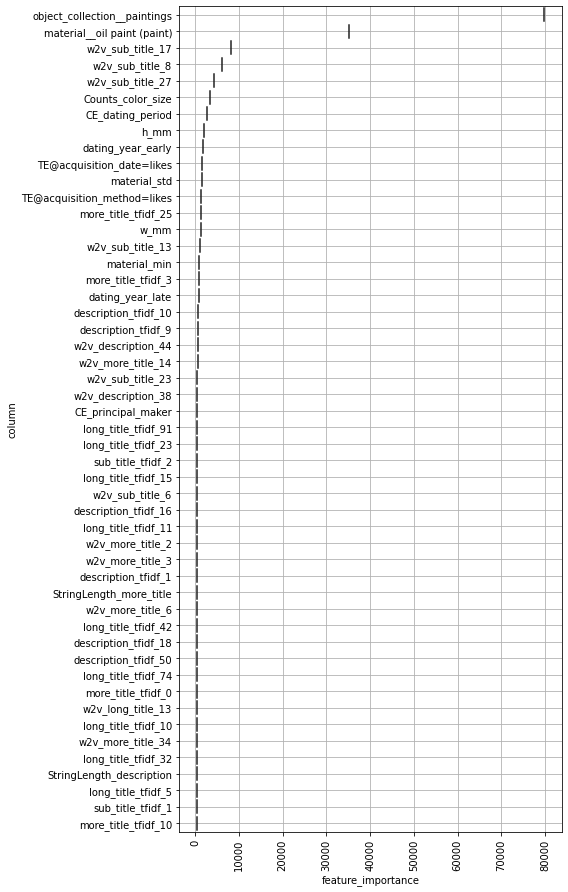

In [91]:
visualize_importance(models, train_feat_df)

## Inference

In [92]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

In [93]:
os.makedirs(output_dir() / 'csv', exist_ok=True)

pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)

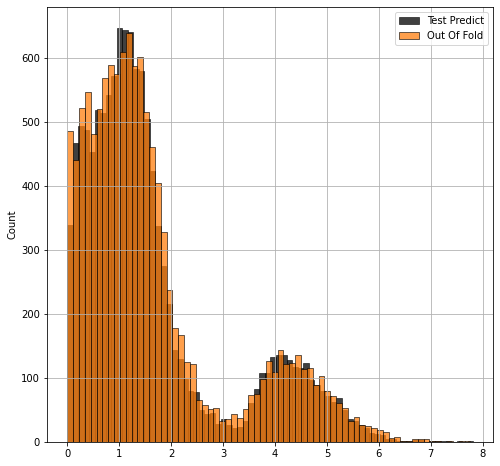

In [94]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(np.log1p(oof_pred), label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

In [95]:
numbering = '0023'

sub_df = pd.DataFrame({ 'likes': pred })

assert len(sub_df) == 12_008

sub_df.to_csv(os.path.join(output_dir() / f'csv/{numbering}__submission.csv'), index=False)

In [143]:
from sklearn.linear_model import Ridge

ridge = Ridge()

ridge.fit(np.log1p(oof_pred.reshape(-1, 1)), np.log1p(y.reshape(-1, 1)))

print(ridge.coef_, ridge.intercept_)

[[1.00757766]] [-0.02350405]


In [144]:
pred_2 = ridge.predict(np.log1p(pred.reshape(-1, 1))).ravel()
pred_2 = revert_to_real(pred_2)

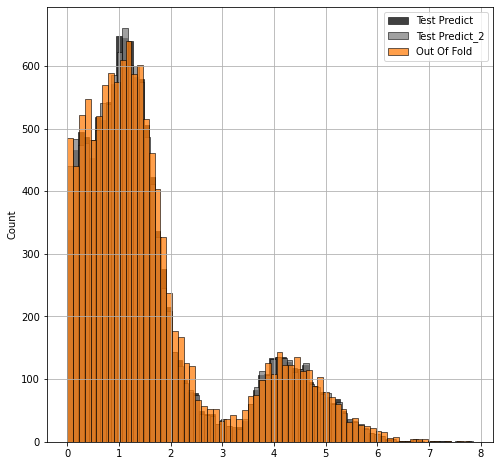

In [145]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(np.log1p(pred_2), label='Test Predict_2', ax=ax, color='gray')

sns.histplot(np.log1p(oof_pred), label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

In [146]:
numbering = '0024'

sub_df = pd.DataFrame({ 'likes': pred_2 })

assert len(sub_df) == 12_008

sub_df.to_csv(os.path.join(output_dir() / f'csv/{numbering}__submission.csv'), index=False)